In [55]:
import pandas as pd

# Example usage
input_csv = "cropped_OH_data_analysis.csv"  # Path to your input CSV file
features_df = pd.read_csv(input_csv)
features_df.rename(columns={"Patient ID": "Patient"}, inplace=True)
print("DataFrame loaded:")
features_df.head()

DataFrame loaded:


,Patient,Cropped CT/GTV Shape,CT/GTV Spacing,CT/GTV Origin,CT/GTV Direction,Tumor Size(mm),Contrast Score,Canny Count(mm³)
0,2015RIJA,"(5, 14, 16)","(1.171875, 1.171875, 3.0)","(-300.0, -327.0, -555.4999389648438)","(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)",46.52,2.30,4395.90
1,2013HOGE,"(6, 18, 22)","(1.171875, 1.171875, 3.0)","(-300.0, -216.0, -735.0)","(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)",63.37,0.56,7625.89
2,2017HOSU,"(8, 23, 19)","(1.35546875, 1.35546875, 3.0)","(-347.0, -322.0, -800.5)","(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)",56.04,0.97,14413.58
3,2013RILI,"(8, 21, 28)","(1.171875, 1.171875, 3.0)","(-300.0, -204.0, -699.0)","(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)",81.85,1.49,14316.56
4,2018DOCA,"(8, 28, 19)","(1.171875, 1.171875, 3.0)","(-300.0, -276.5, -901.3900146484375)","(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)",57.97,0.79,11894.07


In [56]:
import os
import pandas as pd

# Path to the folds directory
base_dir = "/home/ilkin/Documents/2024PHD/segmentation/swinunetr/tests/OH-GLLES-3D/s4/"
num_folds = 5  # Number of folds

def load_metrics_from_folds(base_dir, num_folds):
    all_metrics = []
    
    for fold in range(1, num_folds + 1):
        fold_path = os.path.join(base_dir, f"fold_{fold}")
        dice_file = os.path.join(fold_path, "dice_scores_output.csv")
        hd95_file = os.path.join(fold_path, "hd95_scores_output.csv")
        
        if os.path.exists(dice_file) and os.path.exists(hd95_file):
            dice_df = pd.read_csv(dice_file)
            hd95_df = pd.read_csv(hd95_file)
            
            # Ensure both have the same patients
            merged_df = dice_df.merge(hd95_df, on='Patient')
            merged_df['Fold'] = fold  # Keep track of fold info
            all_metrics.append(merged_df)
    
    return pd.concat(all_metrics, ignore_index=True) if all_metrics else None

# Load data from all folds
metrics_df = load_metrics_from_folds(base_dir, num_folds)
metrics_df.head()


,Patient,Background DICE,Tumor DICE,Background HD95,Tumor HD95,Fold
0,2013HOJA,0.9980,0.8747,0.0000,2.0000,1
1,2012JOJA,0.9912,0.6896,2.2361,6.3638,1
2,2011TSMA,0.9989,0.7865,0.0000,2.2361,1
3,2012ADJU,0.9945,0.5850,1.4142,8.1240,1
4,2015SCWI,0.9985,0.7736,0.0000,2.2361,1


In [57]:
# Compute mean Dice and HD95 for each fold
fold_performance = metrics_df.groupby('Fold').agg({
    'Tumor DICE': 'mean',
    'Tumor HD95': 'mean'
}).reset_index()

fold_performance.head()


,Fold,Tumor DICE,Tumor HD95
0,1,0.806665,3.290465
1,2,0.802188,3.126547
2,3,0.808912,3.321735
3,4,0.809700,3.331259
4,5,0.810182,3.318382


In [58]:
# Aggregate by patient (average across folds)
if metrics_df is not None:
    aggregated_metrics = metrics_df.groupby('Patient').agg({
        'Background DICE': 'mean',  # Average Dice score
        'Tumor DICE': 'mean',   # Average HD95 score
        'Background HD95': 'mean',  # Average Dice score
        'Tumor HD95': 'mean'   # Average HD95 score
    }).reset_index()
    # Filter only test patients present in aggregated_metrics
    test_patients = aggregated_metrics['Patient'].unique()
    filtered_features_df = features_df[features_df['Patient'].isin(test_patients)]

    # Merge only test patients
    final_df = filtered_features_df.merge(aggregated_metrics, on='Patient', how='left')
    
    # Save the updated DataFrame
    #final_df.to_csv("/home/ilkin/Documents/2024PHD/segmentation/cropped_OH_data_with_metrics.csv", index=False)
    print("Updated dataset saved!")
else:
    print("No metric files found.")
final_df.head()

Updated dataset saved!


,Patient,Cropped CT/GTV Shape,CT/GTV Spacing,CT/GTV Origin,CT/GTV Direction,Tumor Size(mm),Contrast Score,Canny Count(mm³),Background DICE,Tumor DICE,Background HD95,Tumor HD95
0,2015SCWI,"(5, 11, 11)","(1.1171875, 1.1171875, 3.0)","(-286.0, -208.0, -742.5)","(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)",30.74,1.30,1924.58,0.99816,0.74408,0.00000,2.99592
1,2018CAJO(1),"(9, 26, 22)","(1.171875, 1.171875, 3.0)","(-300.0, -270.1000061035156, -741.989990234375)","(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)",63.58,4.13,15449.52,0.99788,0.87880,0.00000,2.00000
2,2017HADO,"(6, 17, 12)","(1.365234375, 1.365234375, 3.0)","(-349.5, -241.5, -1282.0)","(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)",34.03,0.83,6715.51,0.99588,0.56760,0.00000,6.30912
3,2017REST,"(7, 19, 18)","(1.064453125, 1.064453125, 3.0)","(-272.5, -201.5, -1483.5)","(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)",52.37,2.24,7070.30,0.99666,0.86442,0.00000,2.38888
4,2017BAHE,"(6, 21, 21)","(1.193359375, 1.193359375, 3.0)","(-305.5, -233.5, -849.5)","(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)",62.66,2.59,8638.63,0.99260,0.85960,1.33136,2.94414


In [67]:
cleaned_df = final_df.drop(columns=['Patient','Cropped CT/GTV Shape','CT/GTV Spacing','CT/GTV Origin','CT/GTV Direction'])

In [68]:
# Convert numeric columns explicitly to avoid string issues
def safe_convert_to_numeric(df):
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Converts non-numeric values to NaN
    return df

# Apply before correlation analysis
final_df = safe_convert_to_numeric(final_df)


In [69]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Exploratory Data Analysis for Model Performance Analysis

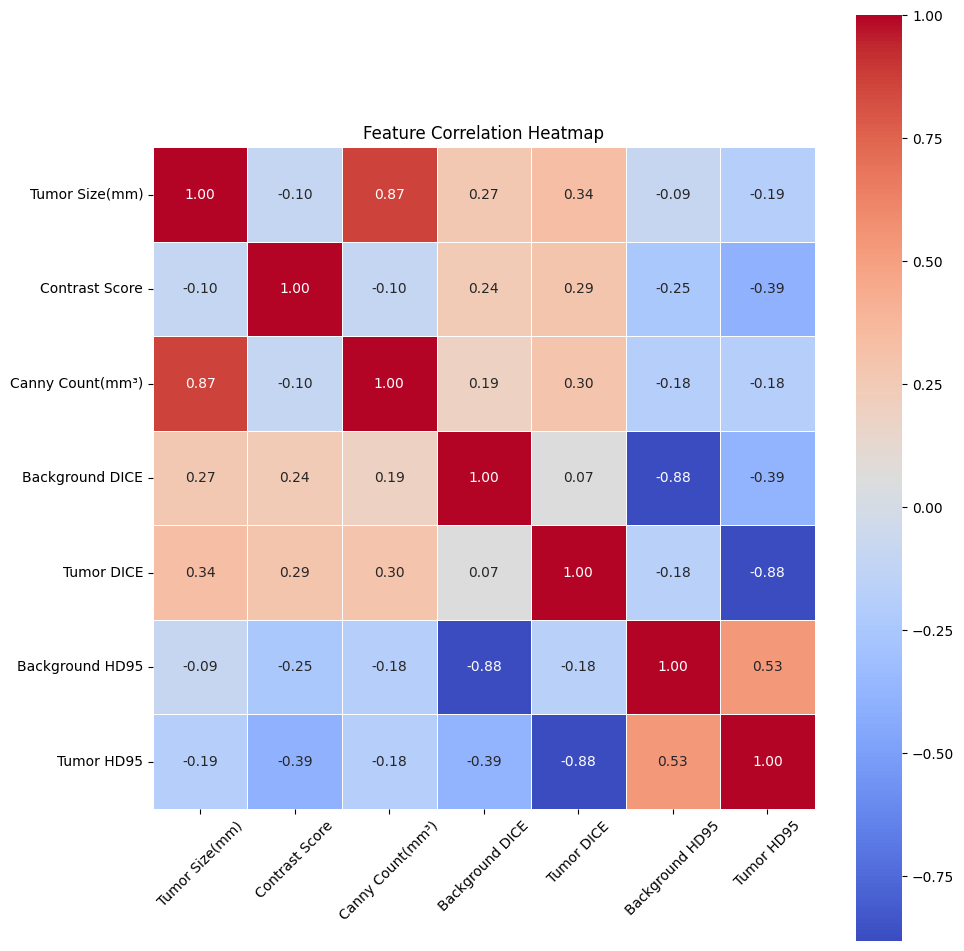

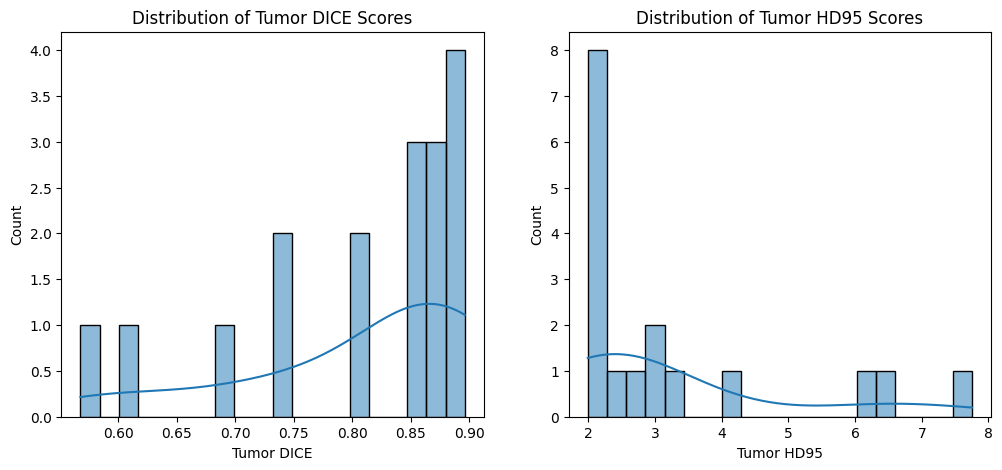

Hard to Segment Cases:
    Patient  Tumor DICE  Tumor HD95  Tumor Size(mm)  Contrast Score
0       NaN     0.74408     2.99592           30.74            1.30
2       NaN     0.56760     6.30912           34.03            0.83
8       NaN     0.68296     6.38562           63.89            1.29
13      NaN     0.61200     7.75452           52.13            0.16
15      NaN     0.73986     3.42816           59.36            0.85


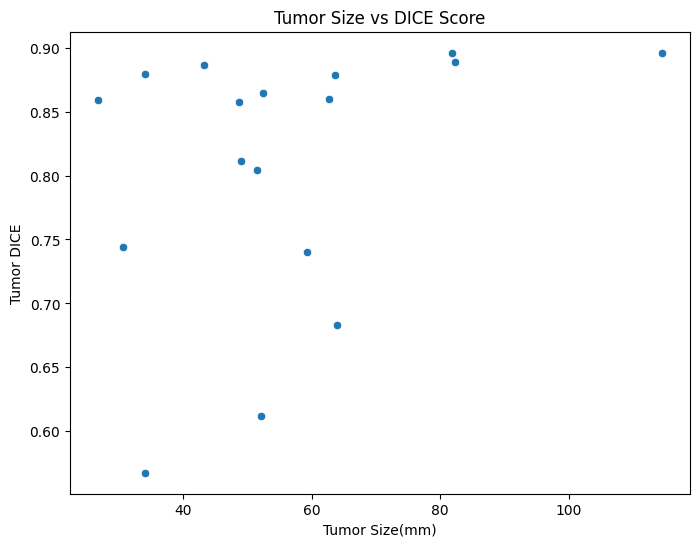

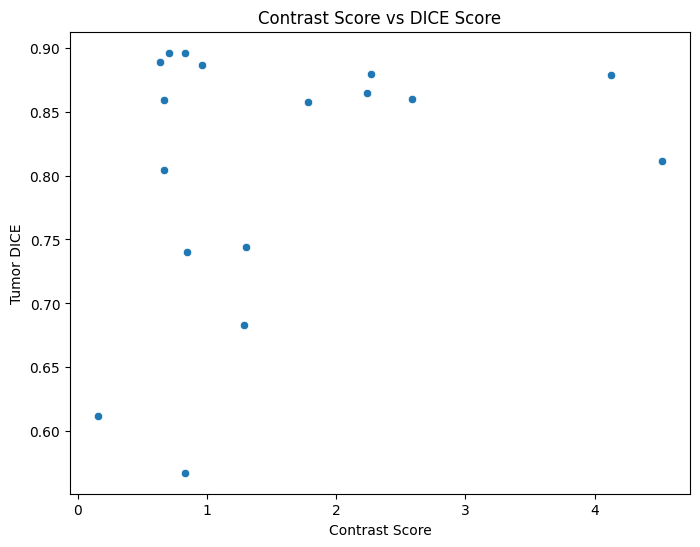

In [70]:
# 1. Correlation Analysis to Identify Key Factors
def correlation_analysis(df):
    plt.figure(figsize=(10, 10))  # Adjust size to make it more proportional
    numerical_df = df.select_dtypes(include=['number'])  # Select only numeric columns
    corr_matrix = numerical_df.corr()
    ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=True)
    plt.title("Feature Correlation Heatmap")
    ax.set_xticks(np.arange(len(corr_matrix.columns)) + 0.5)
    ax.set_yticks(np.arange(len(corr_matrix.columns)) + 0.5)
    ax.set_xticklabels(corr_matrix.columns, rotation=45)  # Ensure proper alignment
    ax.set_yticklabels(corr_matrix.columns, rotation=0)
    plt.tight_layout()
    plt.show()
    
# 2. Distribution of Dice and HD95 Scores
def plot_metric_distributions(df):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(df['Tumor DICE'], bins=20, kde=True, ax=axes[0])
    axes[0].set_title("Distribution of Tumor DICE Scores")
    
    sns.histplot(df['Tumor HD95'], bins=20, kde=True, ax=axes[1])
    axes[1].set_title("Distribution of Tumor HD95 Scores")
    plt.show()

# 3. Identifying Hard to Segment Cases
def hard_case_analysis(df):
    threshold_dice = df['Tumor DICE'].quantile(0.25)  # Bottom 25% as hard cases
    hard_cases = df[df['Tumor DICE'] <= threshold_dice]
    print("Hard to Segment Cases:")
    print(hard_cases[['Patient', 'Tumor DICE', 'Tumor HD95', 'Tumor Size(mm)', 'Contrast Score']])
    return hard_cases

# 4. Effect of Tumor Size on Model Performance
def analyze_tumor_size(df):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x='Tumor Size(mm)', y='Tumor DICE')
    plt.title("Tumor Size vs DICE Score")
    plt.show()

# 5. Contrast Score vs Performance
def analyze_contrast_score(df):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x='Contrast Score', y='Tumor DICE')
    plt.title("Contrast Score vs DICE Score")
    plt.show()

# Execute Analysis
correlation_analysis(cleaned_df)
plot_metric_distributions(final_df)
hard_cases = hard_case_analysis(final_df)
analyze_tumor_size(final_df)
analyze_contrast_score(final_df)


Key Observations:
1. Tumor Size vs. Other Factors

    Tumor Size vs. Canny Count (0.87)
        Strong positive correlation suggests that larger tumors have more detected edges.
        This makes sense because larger tumors exhibit more structural complexity.
    Tumor Size vs. Tumor DICE (0.34)
        Moderate correlation, indicating that larger tumors are segmented more accurately.
        This suggests that small tumors may be harder to segment, possibly due to unclear boundaries.

2. Contrast Score vs. Performance

    Contrast Score vs. Tumor DICE (0.29)
        Slight positive correlation suggests that higher contrast slightly improves segmentation accuracy.
        However, the weak correlation suggests other factors contribute more significantly.
    Contrast Score vs. Tumor HD95 (-0.39)
        Moderate negative correlation, meaning higher contrast leads to better segmentation accuracy (lower HD95 error).
        This highlights that contrast could be an important preprocessing factor for improving segmentation.

3. Background vs. Tumor Segmentation

    Background DICE vs. Tumor DICE (0.07, almost no correlation)
        Suggests that model performance on background and tumor regions is independent.
        This is important as it shows model struggles in tumor segmentation may not impact background segmentation.
    Background DICE vs. Background HD95 (-0.88, strong negative correlation)
        As expected, higher background segmentation accuracy means lower segmentation error (HD95).

4. Tumor HD95 vs. Tumor DICE (-0.88)

    Strong inverse correlation, confirming as segmentation accuracy (Dice) improves, HD95 error reduces.
    This is expected and validates that HD95 is a reliable error metric for segmentation.

Insights for Model Improvement:

✅ Larger tumors are easier to segment → Consider augmenting small tumor cases in training.
✅ Higher contrast improves segmentation → Preprocessing techniques like contrast enhancement could boost performance.
✅ Tumor segmentation struggles are not tied to background segmentation → Focus on tumor-specific enhancements rather than general improvements.
✅ Canny edge count is highly correlated with tumor size → Edge detection may help in refining segmentation.
